<b><h1 align='center'>Pizza Price Prediction </h1></b>
<p style="text-align: center;"> by Janice Liu </p>

<h3>Problem Statement </h3>
<p>The Pizza Price Prediction project is a Machine Learning models to predict the pizza prices of restaurants in the United States based off the median household income of the restaurants' zip codes. 

This problem can be applied to consumers who may use a price prediction model to compare pizza prices in different areas and make informed decisions on where to order from to save money. Another target audience could be pizza chain restaurants. They may use this price prediction model to determine how to optimally price their pizzas in different geographic locations to stay competitive and maximize profits.</p>

<h3>Dataset </h3>
<p>Datafiniti's pizza dataset is downloaded from <a href="https://www.kaggle.com/datasets/datafiniti/pizza-restaurants-and-the-pizza-they-sell">here</a>. This dataset provides over 10,000 pizza entries with 24 different features from 2,278 unique pizza restaurants in the United States. The target variable would be the price of the pizzas given the zip code of the pizza restaurant. 

To determine the income bracket of each zip code, <a href="https://www.kaggle.com/datasets/goldenoakresearch/us-household-income-stats-geo-locations/versions/1?select=US_Income_Kaggle.csv">this</a> dataset was used. It provides over 32,000 records of zip codes with over 11 features, two of them being the zip code and its median household income. By being able to correlate the zipcode to an income bracket, the pizza dataset was then merged with this one to create models that predicted the pizza prices given a certain zipcode.</p>

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.inspection import permutation_importance

from sklearn.inspection import PartialDependenceDisplay

import warnings

from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_wine
import optuna

<h4>Load in the Datasets </h4>
<p>First, Datafiniti's pizza dataset is loaded in and then cleaned up. The zip code, or postal code, feature in the dataset was converted into strings and made uniformed by dropping all the nonexistent ("nan") entries and the suffixes of the postal code. To prevent extreme outliers from skewing the data, the menu.amountMax of each pizza was capped to $100. </p>

In [2]:
# load pizza dataset
input_path = os.getcwd() + "/input"
data_path = input_path + "/pizza.csv"
pizza = pd.read_csv(data_path)

In [3]:
# clean up postal code
pizza['postalCode'] = pizza['postalCode'].astype(str)
pizza = pizza[pizza.postalCode != "nan"]
pizza = pizza[pizza["menus.amountMax"] < 100.0]
    
for i,j in enumerate(pizza['postalCode']):    
    # get rid of '-' postal code suffix
    if "-" in j:
        pizza['postalCode'][i] = pizza['postalCode'][i].split("-")[0]

/var/folders/0f/glct3g514dd7ylpg_7nb05c80000gn/T/ipykernel_5311/3576796121.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza['postalCode'][i] = pizza['postalCode'][i].split("-")[0]


<p>Then, the income dataset was loaded in. Similarly, the zip code feature was casted into string types. </p>

In [4]:
# loading income data
data_path = input_path + "/income.csv"
income = pd.read_csv(data_path,engine='python',encoding='latin1')
income['Zip_Code'] = income['Zip_Code'].astype(str)

<p>The pizza dataset and the income dataset is merged on their zip codes into one dataframe called complete_df, and then plotted. </p>

In [5]:
# join both datasets
pizza_df = pd.DataFrame(pizza)
pizza_df = pizza_df.set_index("postalCode")

income_df = pd.DataFrame(income[["Zip_Code", "Median"]])
income_df = income_df.set_index("Zip_Code")
complete_df = pizza_df.join(income_df, on='postalCode')
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11259 entries, 72120 to 89128
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11259 non-null  object 
 1   dateAdded           11259 non-null  object 
 2   dateUpdated         11259 non-null  object 
 3   address             11259 non-null  object 
 4   categories          11259 non-null  object 
 5   primaryCategories   11259 non-null  object 
 6   city                11259 non-null  object 
 7   country             11259 non-null  object 
 8   keys                11259 non-null  object 
 9   latitude            11259 non-null  float64
 10  longitude           11259 non-null  float64
 11  menuPageURL         1782 non-null   object 
 12  menus.amountMax     11259 non-null  float64
 13  menus.amountMin     11259 non-null  float64
 14  menus.currency      11259 non-null  object 
 15  menus.dateSeen      11259 non-null  object 
 16  menus

<p>The dot graph  shows each entry of the maximum menu prices compared to the household median income of the restaurant zip code, both of which are in United States dollars. From this graph, it can be seen that as the median income increased, although it is not drastic, there are more pizzas that have higher menu maximum prices. 

As shown in this graph, one limitation of this data is that the income dataset does not encapsulate all the zip codes provided by the pizza dataset. Therefore, there is a portion of the data in the $0 median income range that is unusable.

Despite removing some of the outliers previously, there are still some pizzas that are priced significantly higher than the rest. These data points most likely encapsulates the higher end restaurants within each neighborhood, which is more frequent in the higher median income groups. This was another limitation of the dataset, since it does not take into account the variations that determine pizza prices. The quality of the ingredients, the type of restaurant, etc. can all be factors that causes differing ranges of pizza prices. However, with this dataset, the general range of pizza prices can still be determined, which makes it a valid dataset. </p>

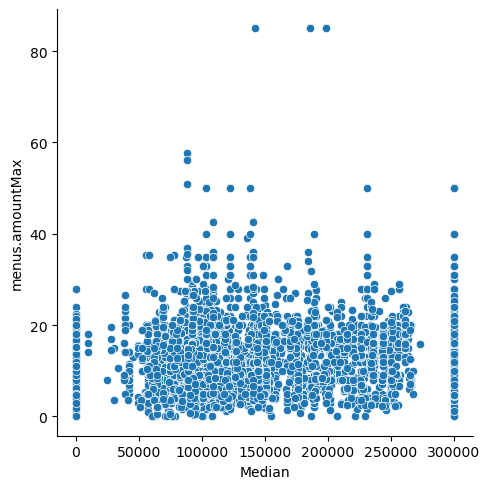

In [6]:
sns.relplot(data=complete_df, x=complete_df["Median"], y=complete_df["menus.amountMax"])

<h4>Transform the Merged Dataset </h4>
<p>The features of the dataset are then transformed for the machine learning models in a pipeline to ensure that multiple transformations occur in the accurate order. First, the SimpleImputer function replaces any missing values in the household median income feature with the mean of all the household median incomes for each pizza entry. Since province, primaryCategories, and city are all features that are object values, OrdinalEncoder is used to convert the strings into integers.</p>

In [7]:
# create master pipeline
data_pipeline = ColumnTransformer(
    transformers=[('imputer', SimpleImputer(strategy='mean'), ['Median']),
                  ('ord1', OrdinalEncoder(), ['province']),
                  ('ord2', OrdinalEncoder(), ['primaryCategories']),
                  ('ord3', OrdinalEncoder(), ['city']),],
    remainder='passthrough')
data_pipeline.set_output(transform="pandas")

df_processed = data_pipeline.fit_transform(complete_df)
df_processed.drop(columns=['remainder__menuPageURL','remainder__menus.description', 'remainder__id', 
                           'remainder__address', 'remainder__country', 'remainder__keys', 
                           'remainder__menus.currency', 'remainder__priceRangeCurrency', 'remainder__name',
                           'remainder__dateAdded', 'remainder__dateUpdated', 'remainder__menus.dateSeen'
                          ], inplace=True)
df_processed.drop(columns=['remainder__categories', 'remainder__menus.name',], inplace=True)
df_processed.info()
df_processed.head()

<class 'pandas.core.frame.DataFrame'>
Index: 11259 entries, 72120 to 89128
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   imputer__Median             11259 non-null  float64
 1   ord1__province              11259 non-null  float64
 2   ord2__primaryCategories     11259 non-null  float64
 3   ord3__city                  11259 non-null  float64
 4   remainder__latitude         11259 non-null  float64
 5   remainder__longitude        11259 non-null  float64
 6   remainder__menus.amountMax  11259 non-null  float64
 7   remainder__menus.amountMin  11259 non-null  float64
 8   remainder__priceRangeMin    11259 non-null  int64  
 9   remainder__priceRangeMax    11259 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.2+ MB


,imputer__Median,ord1__province,ord2__primaryCategories,ord3__city,remainder__latitude,remainder__longitude,remainder__menus.amountMax,remainder__menus.amountMin,remainder__priceRangeMin,remainder__priceRangeMax
postalCode,,,,,,,,,,
72120,93909.000000,2.0,0.0,866.0,34.832300,-92.183800,7.98,7.98,0,25
85012,142758.854152,3.0,0.0,716.0,33.509266,-112.073044,6.00,6.00,0,25
45209,142758.854152,30.0,0.0,169.0,39.144883,-84.432685,6.49,6.49,0,25
48071,142758.854152,19.0,0.0,524.0,42.516669,-83.106630,5.99,5.99,25,40
21224,142758.854152,18.0,0.0,63.0,39.286630,-76.566984,5.49,5.49,0,25


In [8]:
# split model
X, y = df_processed[df_processed.columns.difference(['remainder__menus.amountMax'])], df_processed[['remainder__menus.amountMax']]

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

In [9]:
# RandomForestRegressor model
rf = RandomForestRegressor()
rf.fit(X_train, y_val.values.ravel())

prediction = rf.predict(X_test)
r2_score(y_test, prediction)

ValueError: Found input variables with inconsistent numbers of samples: [9007, 1126]

In [ ]:
# Hyperparameter tuning
param_dist = {"max_depth": [3, 5], 
    "max_features": sp_randint(1, 11), 
    "min_samples_split": sp_randint(2, 11), 
    "bootstrap": [True, False], 
    "criterion": ['friedman_mse', 'poisson', 'absolute_error', 'squared_error']} 

rf = RandomForestRegressor()

# Randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
    n_iter=2, cv=2) 
random_search.fit(X_train, y_train.values.ravel())
hyperparams = random_search.best_params_

In [ ]:
# train model
rf = RandomForestRegressor(**hyperparams)
rf.fit(X_val, y_val.values.ravel())

prediction = rf.predict(X_test)
r2_score(y_test, prediction)

In [ ]:
prediction = rf.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)


In [ ]:
df_processed['remainder__menus.amountMax'].describe()

In [ ]:
y_test_mean = [np.mean(y_test)]*len(y_test)
mse = mean_squared_error(y_test, y_test_mean)
rmse = mse**.5
print(mse)
print(rmse)

In [ ]:
# build second model with xg_boost
#hide warnings
warnings.filterwarnings('ignore')

model = XGBRegressor()
model.fit(X_val, y_val)

# R^2 value for xg_boost model
prediction = model.predict(X_test)
r2_score(y_test, prediction)

In [ ]:
# hyperparameter tuning of XGBoost

# optuna objective function
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    prediction = model.predict(X_test)

    # Evaluate predictions
    accuracy = r2_score(y_test, prediction)
    return accuracy

# optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# print best parameters
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
# refit model
params = trial.params
model = XGBRegressor(**params)
model.fit(X_val, y_val)

# R^2 value for xg_boost model
prediction = model.predict(X_test)
r2_score(y_test, prediction)

In [ ]:
# determining feature importance 
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
# plot partial dependency plot 
features = [0, 6, (0,6)]
PartialDependenceDisplay.from_estimator(rf, X, features)

In [ ]:
# train new model without remainder_menus.amountMin
df_processed.drop(columns=['remainder__menus.amountMin',], inplace=True)

# split model
X, y = df_processed[df_processed.columns.difference(['remainder__menus.amountMax'])], df_processed[['remainder__menus.amountMax']]

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

# train model
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

prediction = rf.predict(X_val)
print(r2_score(y_val, prediction))

In [ ]:
# determining feature importance w/o remainder__princeRangeMax
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# shows that the model needs menu amountMin to have accurate prediction, or else it's dependent on it's coordinate 
# but it wasn't that accurate